#Importo le librerie e i pacchetti necessari

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization, Dropout, LeakyReLU
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Definisco alcune funzioni

In [ ]:
# multi-step data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = list(sequence['Value'][i:end_ix]), list(sequence['Value'][end_ix:out_end_ix])
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features"""
    if not scaler:
        scaler = MinMaxScaler(feature_range=(0.01, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

#alternativamente: StandardScaler()

In [ ]:
#MAE
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def data_preparation(n_steps_in, n_steps_out, train_st, n_features=1):
  # split into samples
  X, y = split_sequence(train_st, n_steps_in, n_steps_out)
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  return X, y

In [ ]:
def plot_finale(train, validation, predicted_val_mean):

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['Value'], color='dimgrey', label='Train')
  plt.plot(validation['Value'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['Value'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['Value'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['Value'][-800:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[-800:], color='tomato', label='Predect')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

#Importo i dati

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/streaming data management/progetto')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)
data.index.freq='H'

Gli LSTM sono sensibili alla scala dei dati di input; è quindi una buona pratica riscalare i dati nell'intervallo tra 0 a 1. Possiamo facilmente normalizzare il set di dati utilizzando la classe di pre-elaborazione MinMaxScaler dalla libreria scikit-learn.

In [ ]:
#Train / validation split
train=data.loc[:"2020-07-01 23:00:00"]
validation=data.loc["2020-07-02 00:00:00":]

train_st=data.loc[:"2020-07-01 23:00:00"].copy()

#Preprocess input data by standardise features
train_st['Value'], scaler = preprocess_data(train_st)

In [ ]:
data_st=data.copy()
data_st['Value'], scaler1 = preprocess_data(data_st)

Per fare le previsioni multi-step ho utilizzato tre diverse stategie:
- previsioni one-step-ahead: le previsioni per gli step successivi al primo si ottengono in modo ricorsivo utilizzando le previsioni precedenti come input per quelle future.
- previsioni direct output vector: il modello prevede direttamente, in un unico colpo, i dati sull'intero intervallo di previsione.
- ibrido: una via di mezzo tra le due strategie precedenti.

Inoltre provo due implementazioni diverse di LSTM: stateful e stateless.
La modalità stateful è utile per avere memoria tra i batch in una epoca di addestramento; se invece non abbiamo abilitato il parametro stateful, l'algoritmo non tiene memoria tra un batch e l'altro.

#modello LSTM (one step prediction - recursive output)

### Implementazione STATEFUL

In [ ]:
n_steps_in, n_steps_out= 24, 1  #24*7
X, y = data_preparation(n_steps_in, n_steps_out, train_st)
n_features=1

In [ ]:
batch_size = 1

# define model
model = Sequential()
model.add(LSTM(100, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True)) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mae')
#model.summary()

#I run the epochs manually to give fine grained control over when resets occur (by default they occur at the end of each batch).
for i in range(3):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

16056/16056 [==============================] - 45s 3ms/step - loss: 0.0207


In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_st[-n_steps_in:])
for i in range(len(validation)):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  prev_st.append(yhat[0][0])
  x_input=np.vstack([x_input, yhat[0]])
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev, index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train)
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train: 275443.2
MAE validation: 633407.8


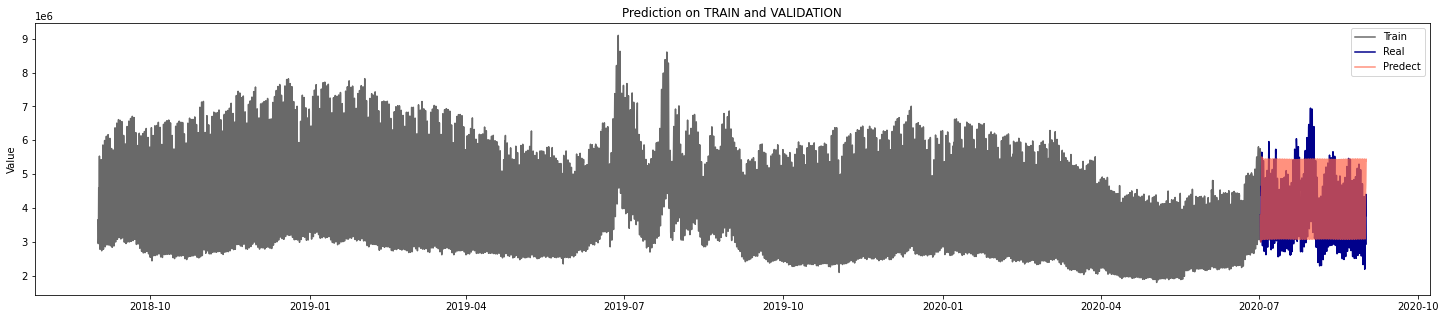

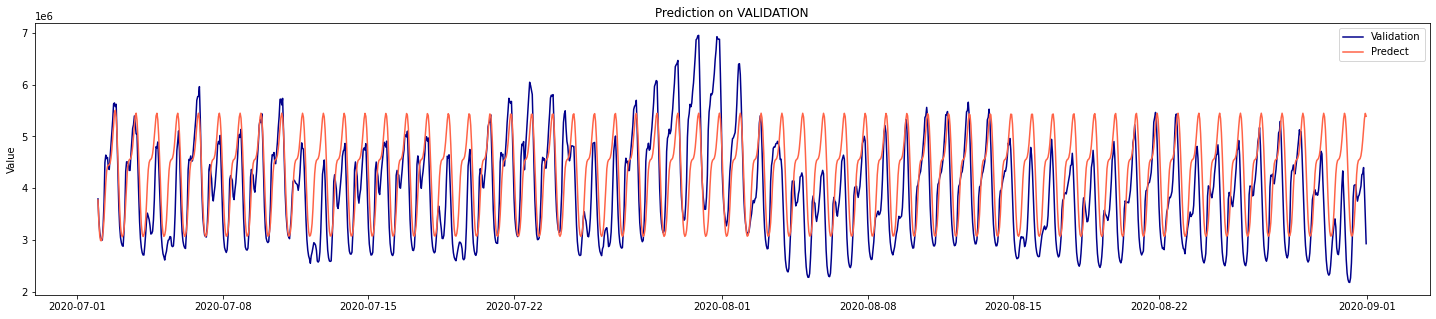

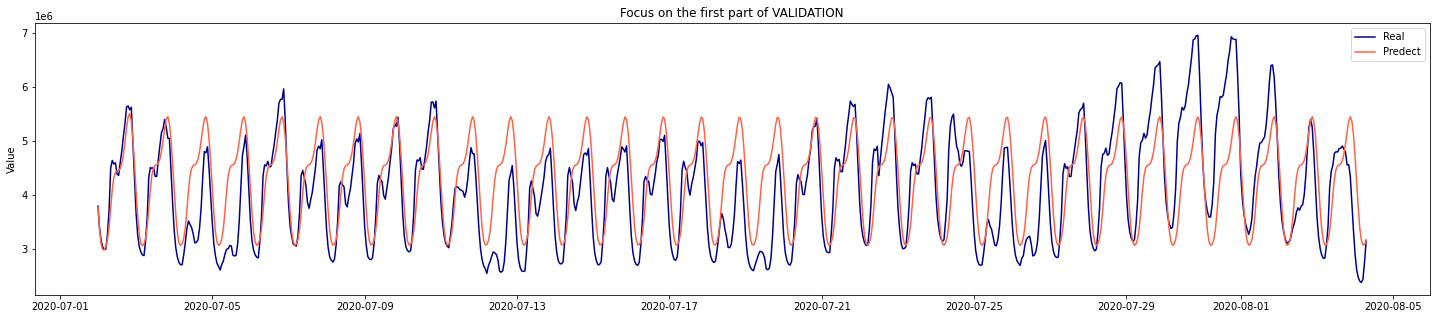

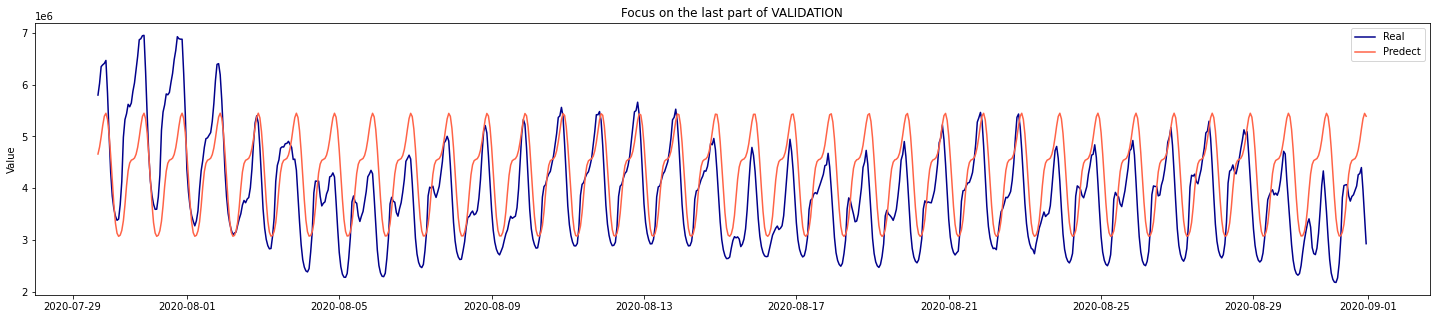

In [ ]:
plot_finale(train, validation, pred_final['Value'])
del model

### Implementazione STATELESS

In [ ]:
n_steps_in, n_steps_out= 24, 1
X, y = data_preparation(n_steps_in, n_steps_out, train_st)
n_features=1

In [ ]:
#define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_steps_in, n_features))) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

model.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
502/502 [==============================] - 3s 4ms/step - loss: 0.1066
Epoch 2/5
502/502 [==============================] - 2s 4ms/step - loss: 0.0405
Epoch 3/5
502/502 [==============================] - 2s 4ms/step - loss: 0.0306
Epoch 4/5
502/502 [==============================] - 2s 4ms/step - loss: 0.0288
Epoch 5/5
502/502 [==============================] - 2s 4ms/step - loss: 0.0264


In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_st[-n_steps_in:])
for i in range(len(validation)):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
  prev_st.append(yhat[0][0])
  x_input=np.vstack([x_input, yhat[0]])

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev, index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train)
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train: 222220.8
MAE validation: 778673.2


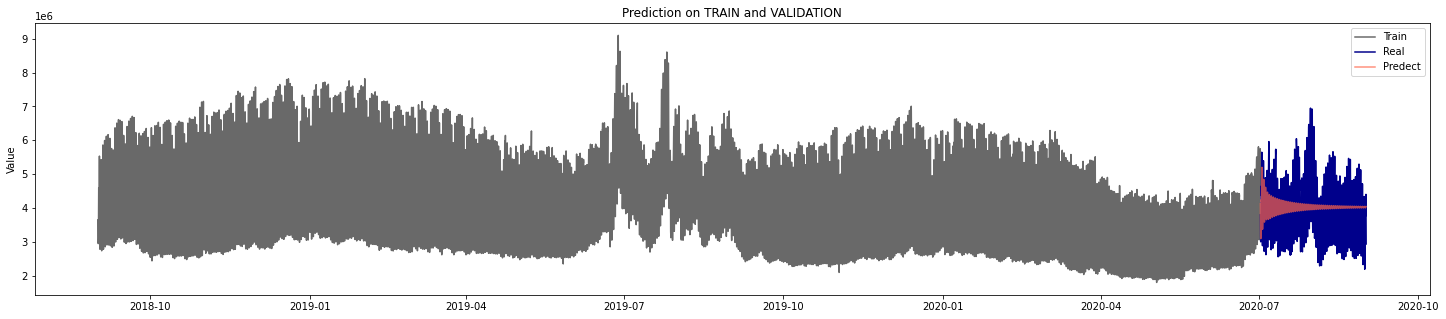

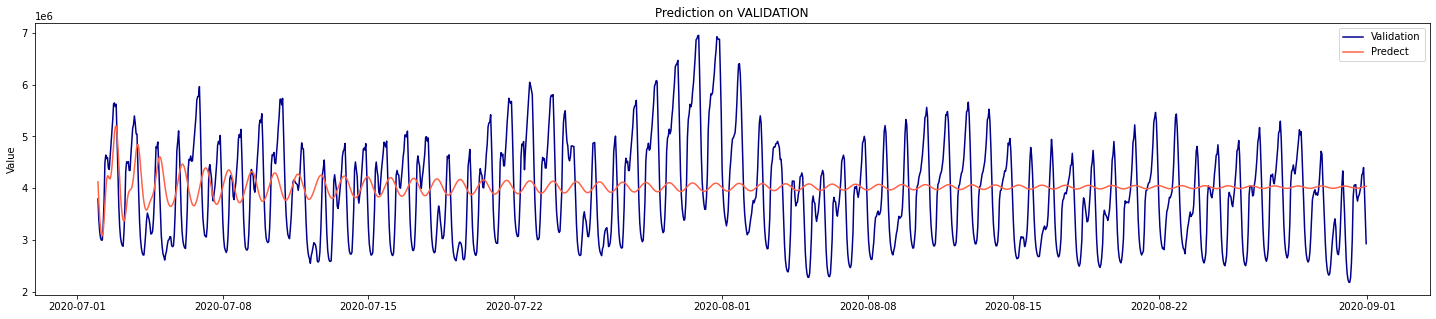

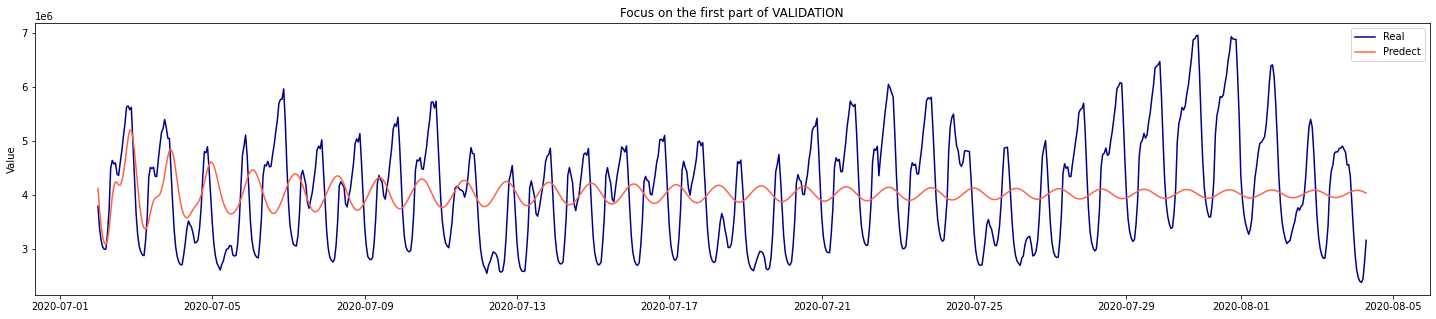

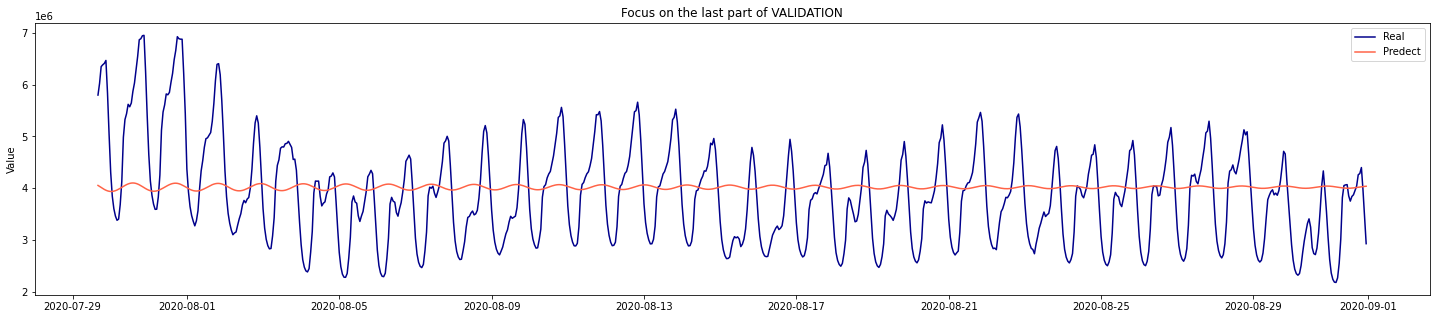

In [ ]:
plot_finale(train, validation, pred_final ['Value'])
del model

#modello LSTM (multistep prediction - direct vector output model)




### Implementazione STATEFUL

In [ ]:
n_features = 1
n_steps_in, n_steps_out= 24*30, 61*24
X, y = data_preparation(n_steps_in, n_steps_out, train_st)

In [ ]:
batch_size = 1

#define model
model = Sequential()
model.add(LSTM(100, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True)) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

for i in range(5):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

13897/13897 [==============================] - 258s 19ms/step - loss: 0.0454


In [ ]:
#prediction on validation set
x_input = np.array(train_st[-n_steps_in:])
yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)

In [ ]:
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train)
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred['Value']))

MAE train: 1311263.2
MAE validation: 932158.1


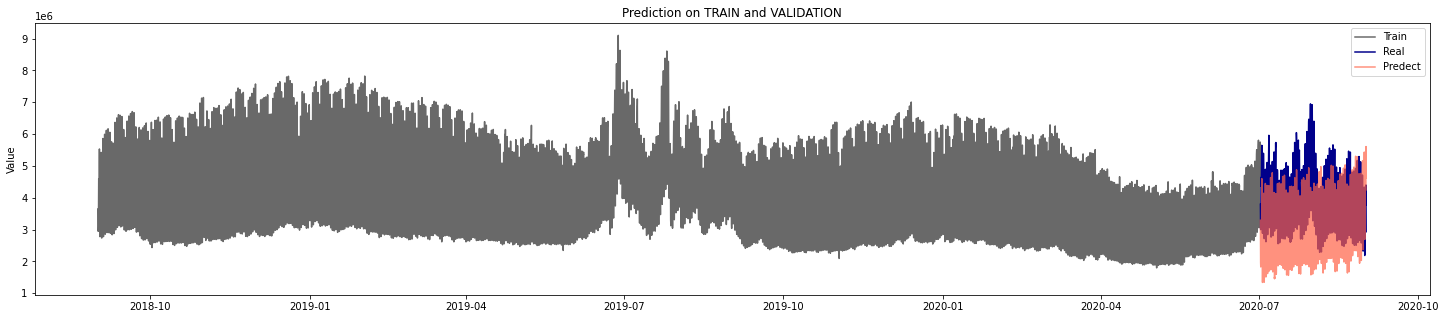

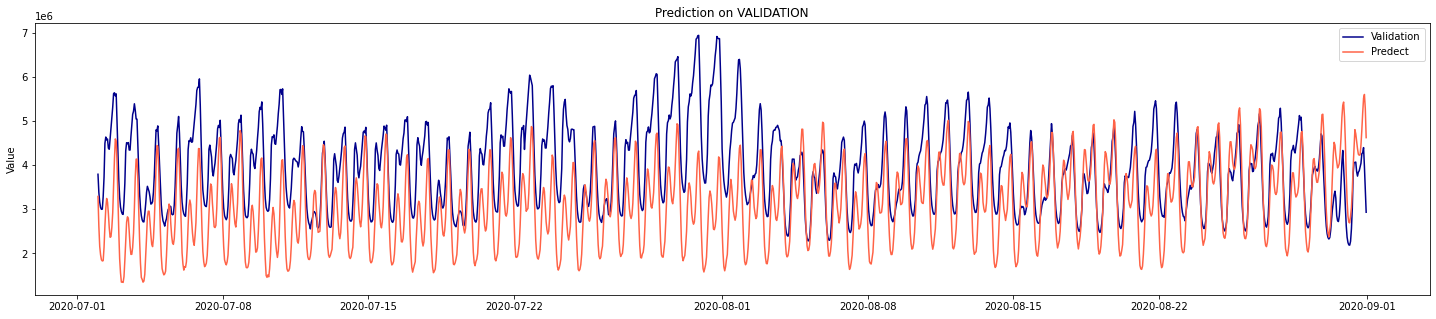

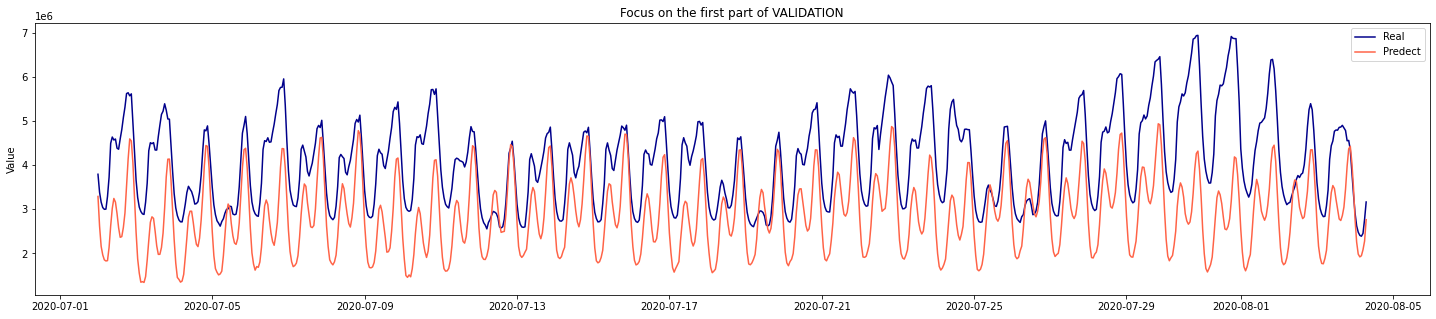

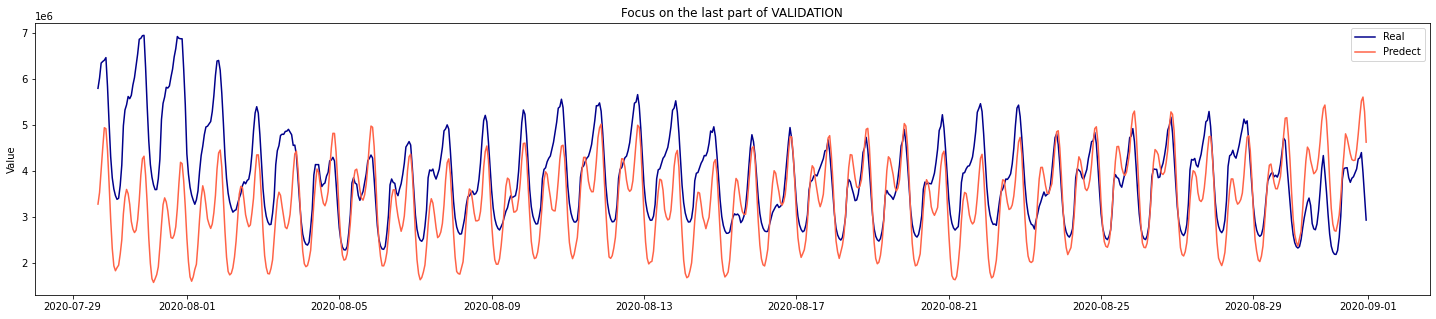

In [ ]:
plot_finale(train, validation, pred['Value'])
del model

### Implementazione STATELESS

In [ ]:
n_features = 1
n_steps_in, n_steps_out= 24*30, 61*24
X, y = data_preparation(n_steps_in, n_steps_out, train_st)

In [ ]:
#define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_steps_in, n_features))) 
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae', metrics='mae')
#model.summary()

model.fit(X, y, epochs=3, verbose=1, shuffle=False)

Epoch 1/3
435/435 [==============================] - 13s 27ms/step - loss: 0.1719 - mae: 0.1719
Epoch 2/3
435/435 [==============================] - 12s 27ms/step - loss: 0.0916 - mae: 0.0916
Epoch 3/3
435/435 [==============================] - 12s 27ms/step - loss: 0.0761 - mae: 0.0761


In [ ]:
#prediction on validation set
x_input = np.array(train_st[-n_steps_in:])
yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)

In [ ]:
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train)
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred['Value']))

MAE train: 1267038.2
MAE validation: 887822.5


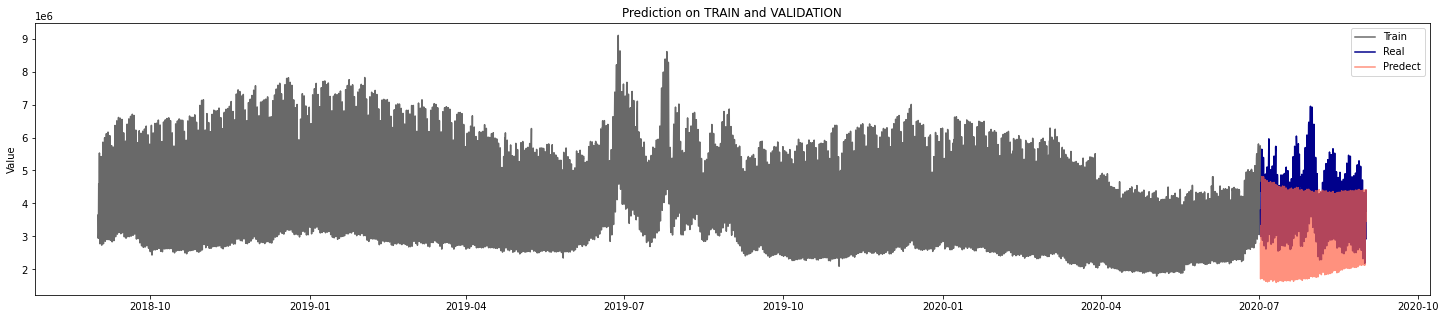

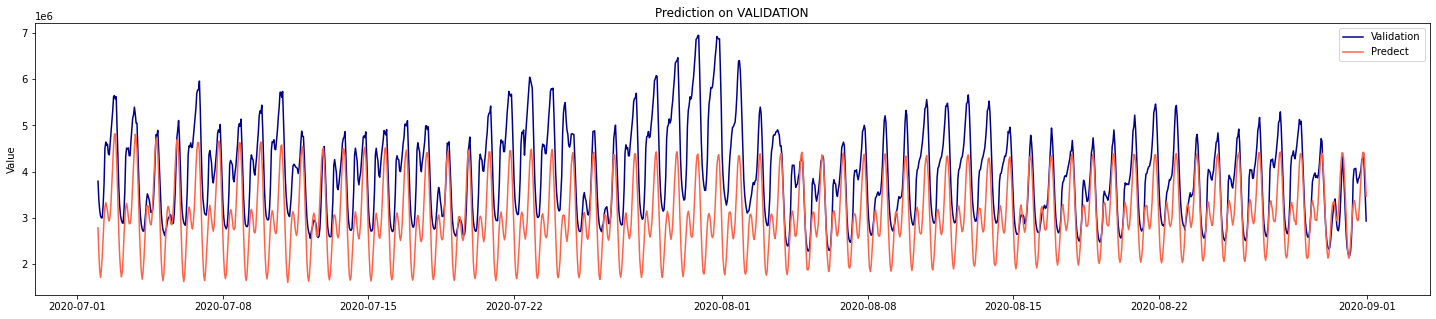

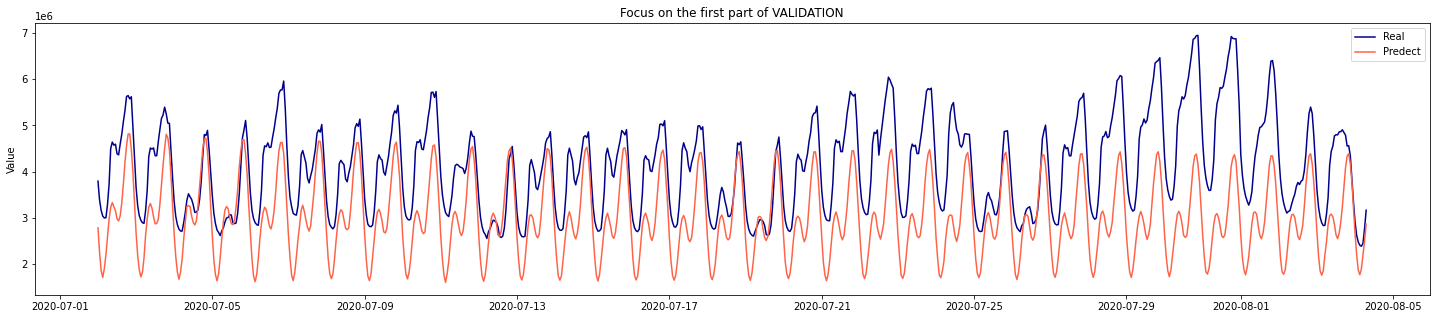

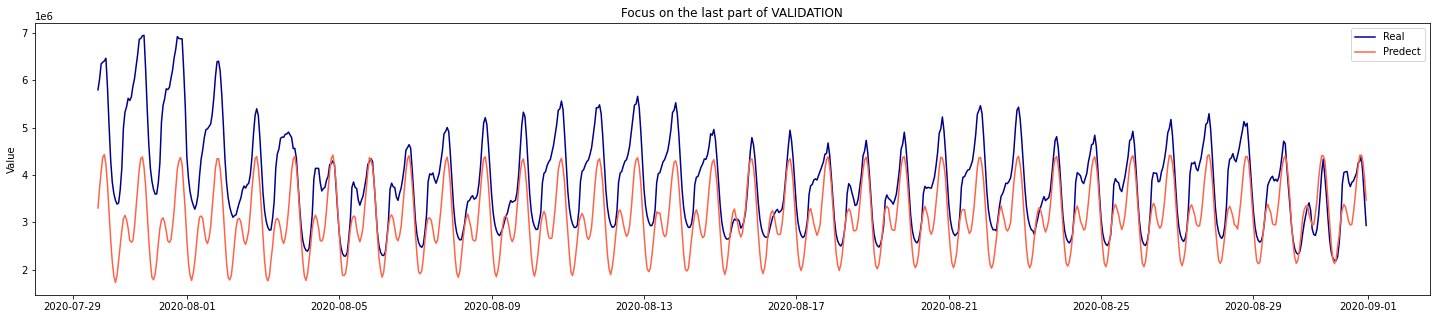

In [ ]:
plot_finale(train, validation, pred['Value'])
del model

#modello LSTM (ibrido)

### Implementazione STATEFUL

In [ ]:
n_steps_in, n_steps_out= 24*7, 24*7

In [ ]:
n_steps_in, n_steps_out= 24*7, 24*7
X, y = data_preparation(n_steps_in, n_steps_out, train_st)
n_features=1

In [ ]:
batch_size = 1

#define model
model = Sequential()
model.add(LSTM(100, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True)) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

for i in range(5):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

15745/15745 [==============================] - 97s 6ms/step - loss: 0.0410


In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_st[-n_steps_in:])
for i in range(int(len(validation)/n_steps_out)+1):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  for j in range(n_steps_out):
    prev_st.append(yhat[0][j])
  x_input=np.vstack([x_input, yhat[0].reshape(yhat[0].shape[0], 1)])
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev[:len(validation)], index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train)
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train: 900726.1
MAE validation: 891638.0


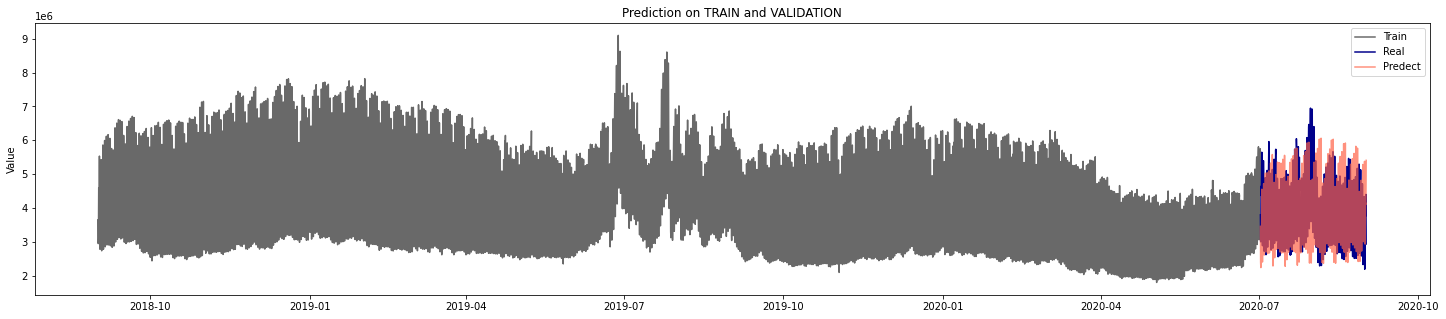

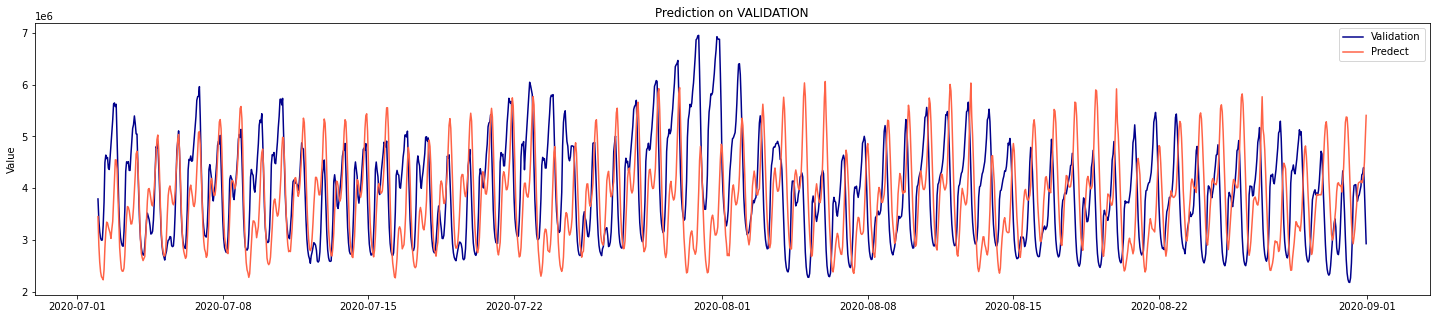

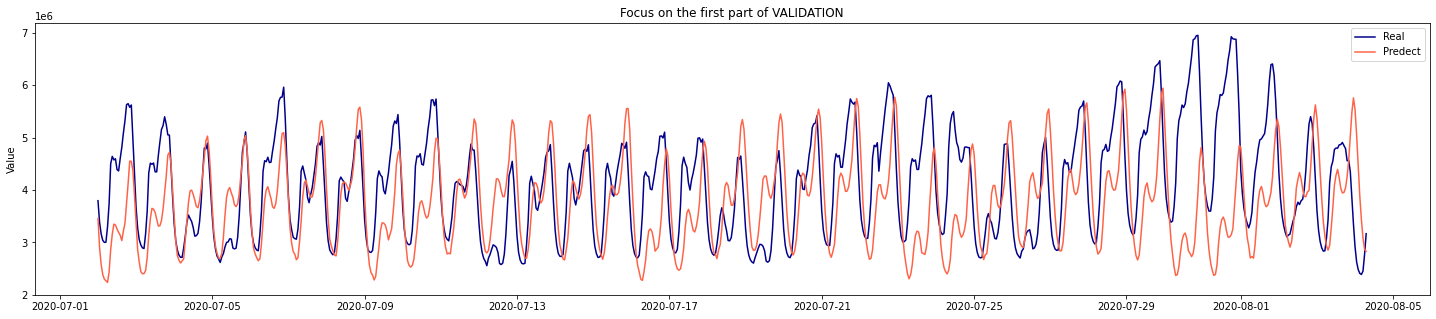

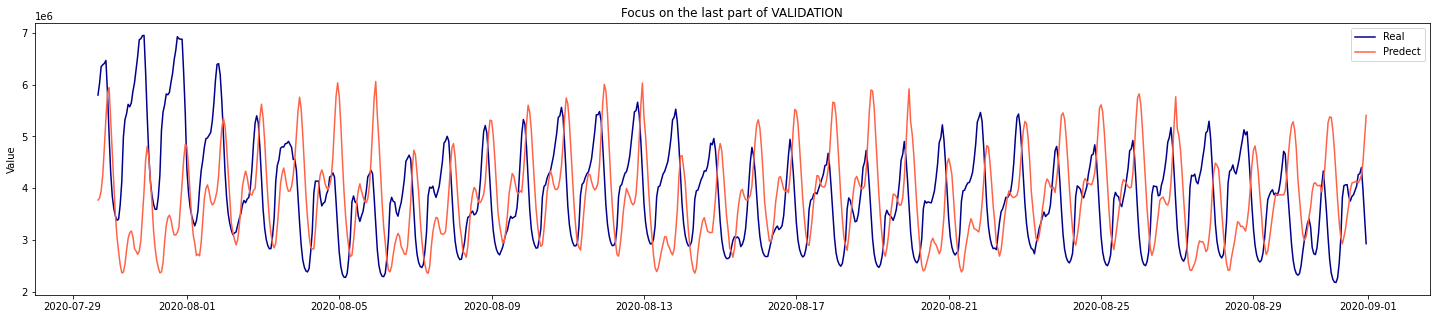

In [ ]:
plot_finale(train, validation, pred_final ['Value'])
del model

### Implementazione STATELESS

In [ ]:
n_steps_in, n_steps_out= 24*31, 24*31
X, y = data_preparation(n_steps_in, n_steps_out, train_st)
n_features=1

In [ ]:
#define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_steps_in, n_features))) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

model.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
457/457 [==============================] - 209s 454ms/step - loss: 0.1728
Epoch 2/5
457/457 [==============================] - 260s 568ms/step - loss: 0.0915
Epoch 3/5
457/457 [==============================] - 261s 570ms/step - loss: 0.1343
Epoch 4/5
457/457 [==============================] - 259s 567ms/step - loss: 0.0843
Epoch 5/5
457/457 [==============================] - 261s 570ms/step - loss: 0.0768


In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_st[-n_steps_in:])
for i in range(int(len(validation)/n_steps_out)+1):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
  for j in range(n_steps_out):
    prev_st.append(yhat[0][j])
  x_input=np.vstack([x_input, yhat[0].reshape(yhat[0].shape[0], 1)])
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev[:len(validation)], index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train)
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train: 1077271.0
MAE validation: 634172.1


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 744)               75144     
Total params: 115,944
Trainable params: 115,944
Non-trainable params: 0
_________________________________________________________________


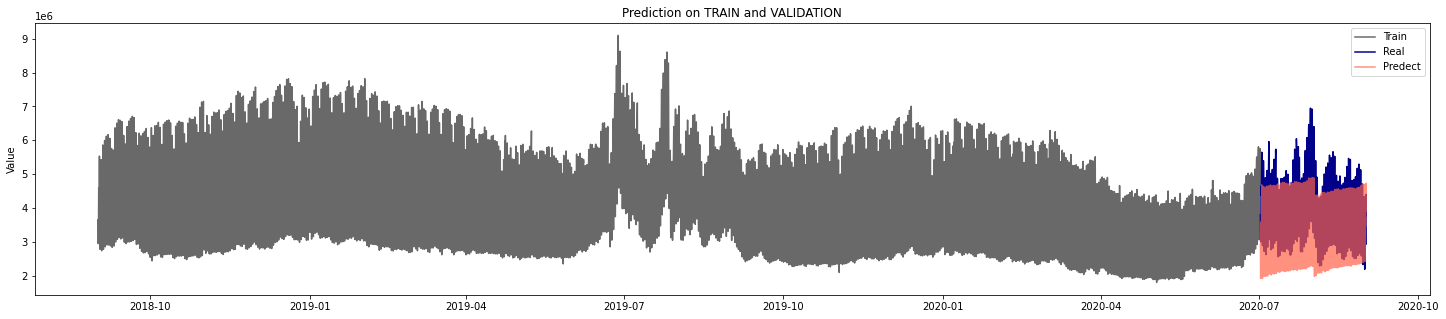

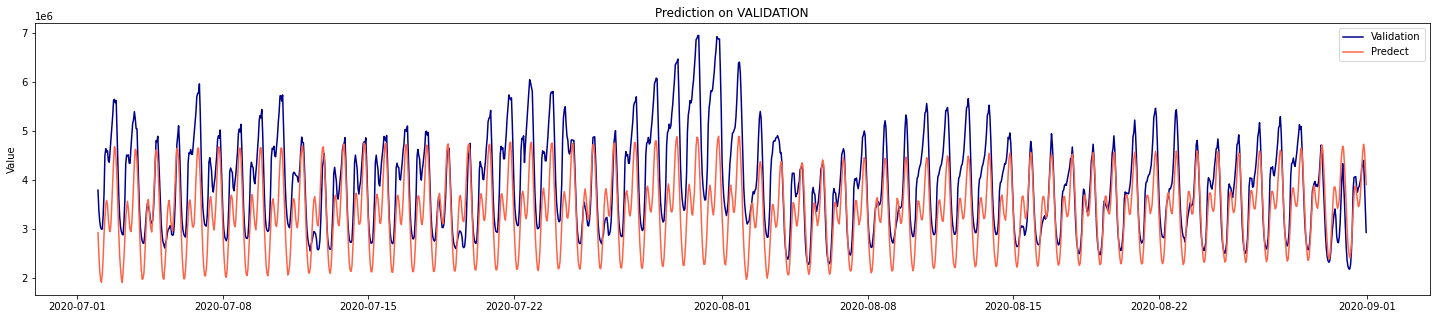

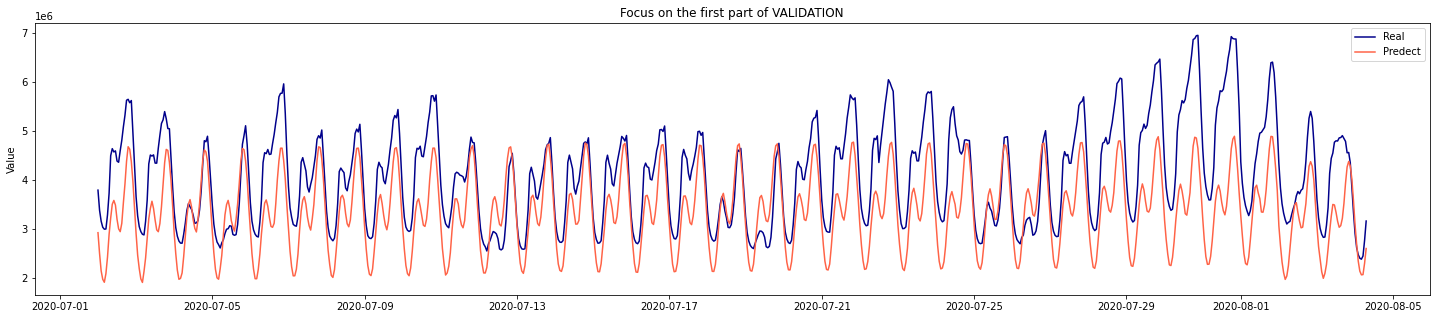

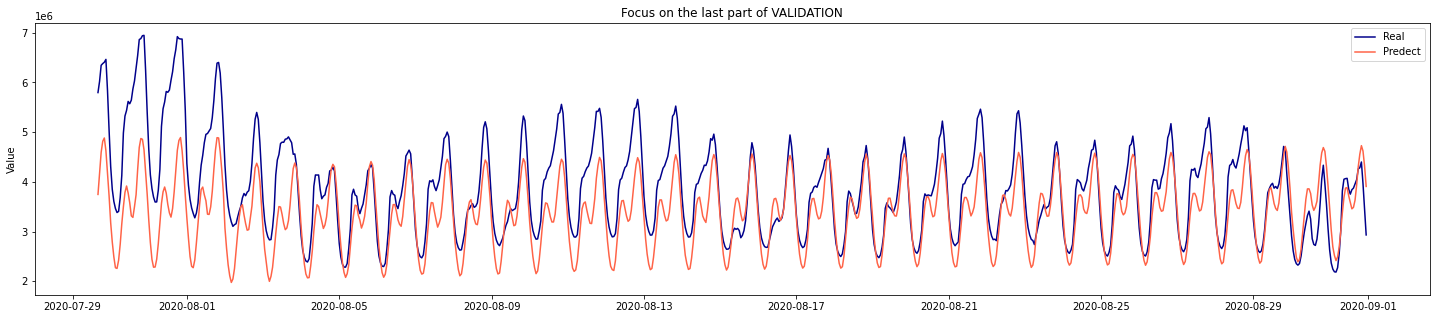

In [ ]:
plot_finale(train, validation, pred_final ['Value'])
del model

I modelli provati non sono eccessivamente performanti.
Forse si potrebbero ottenere migliori performance lavorando con la serie resa stazionaria attraverso delle differenze. 
Oppure si potrebbero applicare degli aggiustamenti stagionali prima della modellazione.

Data la multistagionalità dei dati potrebbe essere opportuno applicare una CNN, una CNN-LSTM o un modello encoder-decoder. Questo poichè una LSTM lineare spesso si comporta male sui problemi di serie temporali.





# Previsioni

In [ ]:
n_features = 1
n_steps_in, n_steps_out= 24*31, 24*31
X, y = data_preparation(n_steps_in, n_steps_out, data_st)

In [ ]:
#define model
model = Sequential()
model.add(LSTM(200, input_shape=(n_steps_in, n_features))) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

model.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
502/502 [==============================] - 20s 37ms/step - loss: 0.1557
Epoch 2/5
502/502 [==============================] - 18s 37ms/step - loss: 0.0700
Epoch 3/5
502/502 [==============================] - 18s 36ms/step - loss: 0.0606
Epoch 4/5
502/502 [==============================] - 18s 36ms/step - loss: 0.0579
Epoch 5/5
502/502 [==============================] - 18s 36ms/step - loss: 0.0579


In [ ]:
len_for=len(pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H'))

In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(data_st[-n_steps_in:])
for i in range(int(len_for/n_steps_out)+1):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
  for j in range(n_steps_out):
    prev_st.append(yhat[0][j])
  x_input=np.vstack([x_input, yhat[0].reshape(yhat[0].shape[0], 1)])
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev[:len(validation)], index=validation.index, columns=['Value'])

In [ ]:
forecast = pd.DataFrame({'LSTM': prev_st[:len_for], 'Date': pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H')})
forecast.set_index('Date', inplace=True)
forecast['LSTM'] = scaler1.inverse_transform(forecast)

In [ ]:
forecast.reset_index(inplace=True)

In [ ]:
forecast.to_csv('LSTM.csv')